In [3]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
user_name = 'sjs70'  # 윈도우 사용자 이름으로 변경하세요
desktop_path = f'C:\\Users\\{user_name}\\Downloads\\dog_eye'

In [5]:
symptom = 'E09'

# 이미지 경로 설정
train_asym_img_path = os.path.join(desktop_path, f'seg_train\\asym\\{symptom}')
train_sym_img_path = os.path.join(desktop_path, f'seg_train\\sym\\{symptom}')
validation_asym_img_path = os.path.join(desktop_path, f'seg_val\\asym\\{symptom}')
validation_sym_img_path = os.path.join(desktop_path, f'seg_val\\sym\\{symptom}')

In [6]:
# 이미지 로드 및 라벨 생성 함수
def load_images_and_labels(sym_paths, asym_paths):
    images = []
    labels = []
    extensions = ['*.jpg', '*.jpeg', '*.png']  # 지원할 파일 확장자 목록

    for path in sym_paths:
        for ext in extensions:
            sym_images = glob.glob(os.path.join(path, ext))
            for image_path in sym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(1)  # 'sym' 라벨

    for path in asym_paths:
        for ext in extensions:
            asym_images = glob.glob(os.path.join(path, ext))
            for image_path in asym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(0)  # 'asym' 라벨

    # 로드된 이미지와 라벨 개수 출력
    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    
    return np.array(images), np.array(labels)

In [7]:
# 훈련 및 검증 데이터 로드
train_images_sym, train_labels_sym = load_images_and_labels([train_sym_img_path], [])
train_images_asym, train_labels_asym = load_images_and_labels([], [train_asym_img_path])
val_images_sym, val_labels_sym = load_images_and_labels([validation_sym_img_path], [])
val_images_asym, val_labels_asym = load_images_and_labels([], [validation_asym_img_path])

Loaded 9601 images and 9601 labels.
Loaded 9600 images and 9600 labels.
Loaded 1196 images and 1196 labels.
Loaded 1200 images and 1200 labels.


In [8]:
# sym 파일과 asym 파일 각각 결합
sym_images = np.concatenate([train_images_sym, val_images_sym], axis=0)
sym_labels = np.concatenate([train_labels_sym, val_labels_sym], axis=0)
asym_images = np.concatenate([train_images_asym, val_images_asym], axis=0)
asym_labels = np.concatenate([train_labels_asym, val_labels_asym], axis=0)

In [9]:
# sym과 asym 개수 세기
sym_count = len(sym_labels)
asym_count = len(asym_labels)

# 데이터 개수 출력
print(f"Symptomatic images: {sym_count}")
print(f"Asymptomatic images: {asym_count}")

Symptomatic images: 10797
Asymptomatic images: 10800


In [10]:
# 부족한 클래스에 맞춰 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

if sym_count < asym_count:
    augmentation_target = sym_images
    augmentation_target_label = 1
    target_count = asym_count
else:
    augmentation_target = asym_images
    augmentation_target_label = 0
    target_count = sym_count

augmented_images = []
augmented_labels = []

for img in augmentation_target:
    img = img.reshape((1,) + img.shape)  # (1, 224, 224, 3) 형태로 변환
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype(np.uint8))  # 메모리 절약을 위해 dtype 변경
        augmented_labels.append(augmentation_target_label)
        i += 1
        if len(augmented_labels) + len(augmentation_target) >= target_count:
            break

In [11]:
# 증강된 데이터와 원본 데이터 결합
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

if augmentation_target_label == 1:
    sym_images = np.concatenate([sym_images, augmented_images], axis=0)
    sym_labels = np.concatenate([sym_labels, augmented_labels], axis=0)
else:
    asym_images = np.concatenate([asym_images, augmented_images], axis=0)
    asym_labels = np.concatenate([asym_labels, augmented_labels], axis=0)

In [12]:
# 결합된 최종 데이터셋
images = np.concatenate([sym_images, asym_images], axis=0)
labels = np.concatenate([sym_labels, asym_labels], axis=0)

In [13]:
# 데이터를 8:2 비율로 train과 test로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# train_val 데이터를 3:1 비율로 train과 validation으로 나누기 (전체 데이터의 6:2:2 비율)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [14]:
def normalize_batch(data, batch_size):
    num_batches = int(np.ceil(len(data) / batch_size))
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(data))
        data[start:end] = data[start:end] / 255.0

# 배치 사이즈 설정
batch_size = 1000

# 데이터 정규화
normalize_batch(X_train, batch_size)
normalize_batch(X_val, batch_size)
normalize_batch(X_test, batch_size)

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # conv_1_filter=32, conv_1_kernel=3
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),  # conv_2_filter=64, conv_2_kernel=5
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),  # conv_3_filter=64, conv_3_kernel=5
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),  # conv_4_filter=32, conv_4_kernel=3
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # dense_units=128
    Dropout(0.3),  # dropout=0.3
    Dense(1, activation='sigmoid')  # 이진 분류를 위해 출력 노드 수를 1로 설정하고, 활성화 함수를 sigmoid로 설정
])

C:\Users\sjs70\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# 테스트 데이터셋을 사용하여 최종 모델 평가
test_score = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_score[1]}')

Epoch 1/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - accuracy: 0.6654 - loss: 0.6048 - val_accuracy: 0.6666 - val_loss: 0.5797
Epoch 2/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.6688 - loss: 0.5763 - val_accuracy: 0.6666 - val_loss: 0.5689
Epoch 3/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - accuracy: 0.6734 - loss: 0.5670 - val_accuracy: 0.6998 - val_loss: 0.5571
Epoch 4/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.7131 - loss: 0.5462 - val_accuracy: 0.7253 - val_loss: 0.5377
Epoch 5/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.7318 - loss: 0.5268 - val_accuracy: 0.7182 - val_loss: 0.5323
Epoch 6/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 602s 990ms/step - accuracy: 0.7308 - loss: 0.5206 - val_accuracy: 0.7301 - val_loss: 0.5257
Epoch 7/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 596s 981ms/step - accuracy: 0.7368 - loss: 0.5110 - val_accuracy: 0.7305 - val_loss: 0.5222
Epoch 8/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 584s 961ms/step - accuracy: 0.7466 - loss: 0.5027 -

In [18]:
# 모델 저장
model.save('E9_Custom_CNN.keras', include_optimizer=True)
print("Model saved as E9_Custom_CNN.keras")

Model saved as E9_Custom_CNN.keras


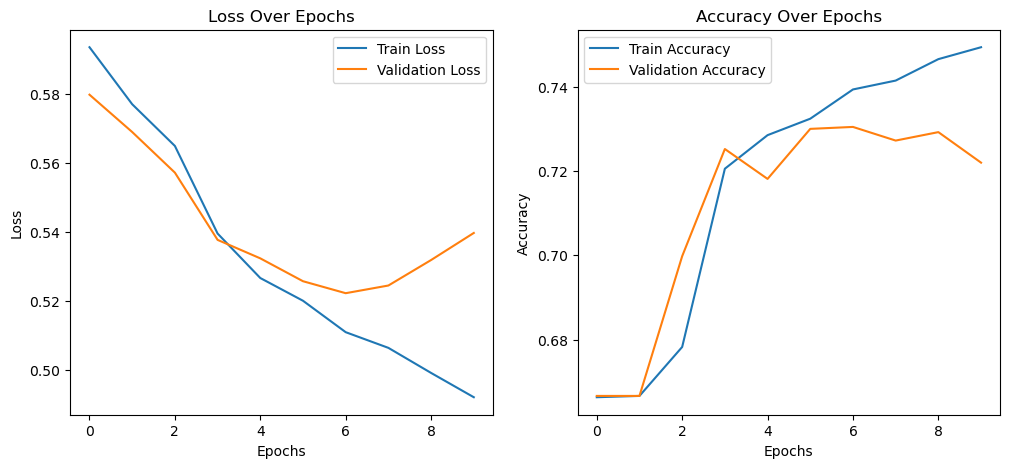

In [19]:
# 훈련 및 검증 손실 플로팅
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 플로팅
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프를 파일로 저장
plt.savefig('E9_training_validation_loss_accuracy.png')
plt.show()

In [20]:
# 예측값 계산
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

203/203 ━━━━━━━━━━━━━━━━━━━━ 53s 261ms/step


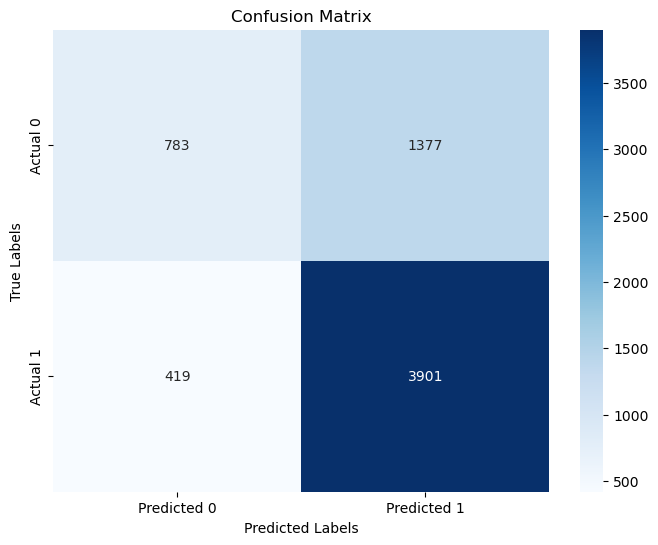

In [21]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# 그래프를 파일로 저장
plt.savefig('E9_confusion_matrix.png')
plt.show()

In [22]:
# 개별 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.7228395061728395
Precision: 0.7391057218643425
Recall: 0.9030092592592592
F1 Score: 0.8128776828505939


In [23]:
# AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC Score: {auc}')

AUC Score: 0.7480281742969821
